## Estimate the number of Richardson-Lucy (RL) deconvolution iterations

One issue with iterative deconvolution algorithms is the lack of clear stopping criteria. This example demonstrates how use image quality measures (PSNR, SSIM, and FRC) to track the progress of GPU-based RL deconvolution.

In [1]:
import matplotlib.pyplot as plt
from skimage.io import imread

from cubic.cuda import ascupy, asnumpy
from cubic.metrics import psnr, ssim, frc_resolution
from cubic.preprocessing import deconv_iter_num_finder

/hpc/mydata/alex.kalinin/anaconda/latest/x86_64/envs/vs/lib/python3.12/site-packages/cupy/_environment.py:596: UserWarning: 
--------------------------------------------------------------------------------

  CuPy may not function correctly because multiple CuPy packages are installed
  in your environment:

    cupy, cupy-cuda12x

  Follow these steps to resolve this issue:

    1. For all packages listed above, run the following command to remove all
       existing CuPy installations:

         $ pip uninstall <package_name>

      If you previously installed CuPy via conda, also run the following:

         $ conda uninstall cupy

    2. Install the appropriate CuPy package.
       Refer to the Installation Guide for detailed instructions.

         https://docs.cupy.dev/en/stable/install.html

--------------------------------------------------------------------------------

  warnings.warn(f'''


### Load data and the PSF

A single 3D stack of Hoechst-stained astrocyte nuclei acquired with a Yokogawa CQ1 confocal microscope.
Theoretical 3D point spread function (PSF) was modeled using the Richards and Wolf algorithm from the PSFGenerator plugin for Fiji [1].
The image and the PSF can be [downloaded from Google Drive](../data/README.md).

In [2]:
scale_xy = 0.1625
scale_z = 0.3
voxel_sizes = (scale_z, scale_xy, scale_xy)

image = imread("../data/astr_vpa_hoechst.tif")
psf = imread("../data/astr_vpa_hoechst_psf_na095.tif")

image = ascupy(image)
psf = ascupy(psf)

Both image and the PSF have the same ZYX size of $30 \times 2160 \times 2560$.

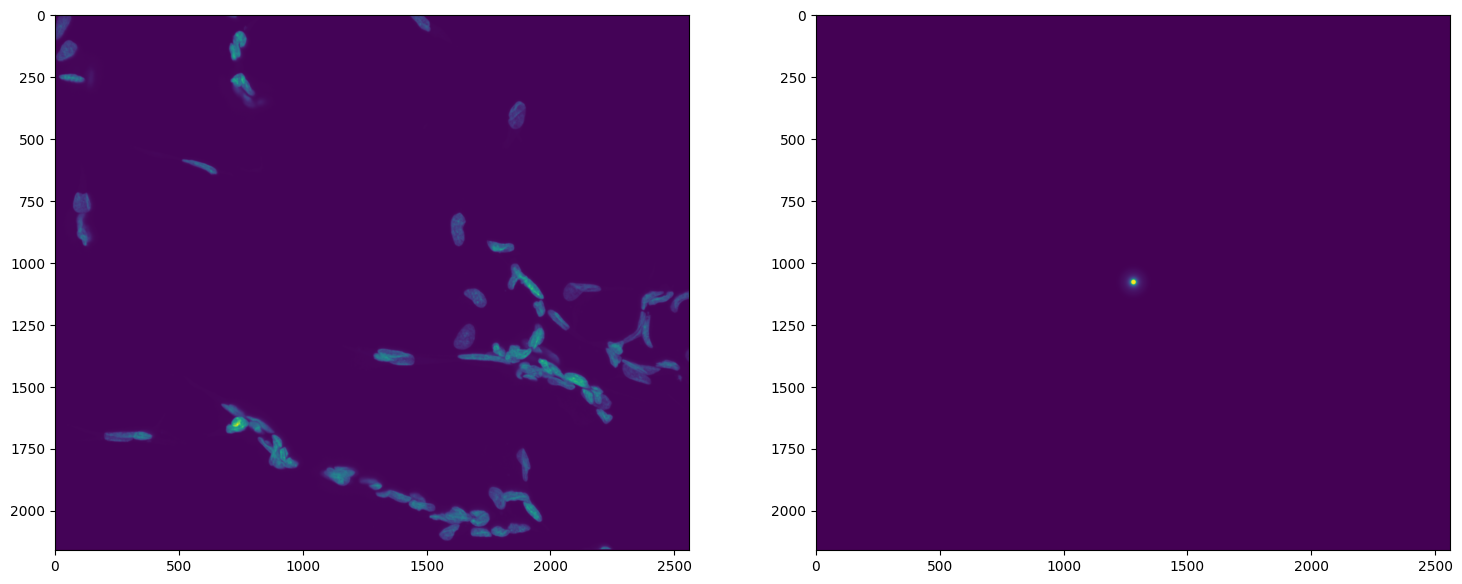

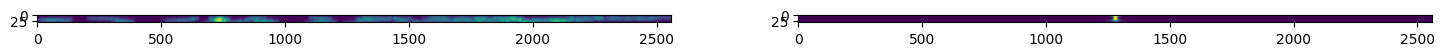

In [3]:
fig, axes = plt.subplots(1, 2, figsize=(18, 18))
axes[0].imshow(asnumpy(image.max(0)))
axes[1].imshow(asnumpy(psf.max(0)), vmax=0.01)
plt.show()
fig, axes = plt.subplots(1, 2, figsize=(18, 18))
axes[0].imshow(asnumpy(image.max(1)))
axes[1].imshow(asnumpy(psf.max(1)), vmax=0.01)
plt.show()

### Use PSNR improvement as a metric of decon quality

Here we demonstrate how to use peak signal-to-noise ratio (PSNR) as a criteria for determining the number of RL iterations.
cubic will run RL on a GPU and at each iteration compare restored image with one from the previous iteration using psnr also calculated on GPU.
By default, images are padded in Z in 'reflect' mode on both sides up to 32 slices.

When provided threshold is reached, it returns the number of iterations and an object metric gains and intermediate images from all iterations.
Note that the RL will run for full `max_iter` iterations.

We use fast RL `xpy` implementation adapted from `tnia-python` library [2].

In [4]:
psnr_thresh_iter, psnr_resolution = deconv_iter_num_finder(
    image,
    psf,
    metric_fn=psnr,
    metric_kwargs={"scale_invariant": True},
    metric_threshold=80.0,
    max_iter=35,
    verbose=True,
    implementation="xpy",
)

Iteration 1: improvement 49.92705773
Iteration 2: improvement 54.67385750
Iteration 3: improvement 57.66132966
Iteration 4: improvement 59.87482761
Iteration 5: improvement 61.71348928
Iteration 6: improvement 63.27595486
Iteration 7: improvement 64.63043260
Iteration 8: improvement 65.82847360
Iteration 9: improvement 66.90407383
Iteration 10: improvement 67.88084840
Iteration 11: improvement 68.77583805
Iteration 12: improvement 69.60179208
Iteration 13: improvement 70.36849329
Iteration 14: improvement 71.08358336
Iteration 15: improvement 71.76563571
Iteration 16: improvement 72.43259025
Iteration 17: improvement 73.09693851
Iteration 18: improvement 73.79620560
Iteration 19: improvement 74.46534340
Iteration 20: improvement 75.10658629
Iteration 21: improvement 75.72187316
Iteration 22: improvement 76.31286441
Iteration 23: improvement 76.88105330
Iteration 24: improvement 77.42779320
Iteration 25: improvement 77.95427648
Iteration 26: improvement 78.46159814
Iteration 27: improve

Now we can visualize the progress according to the provided metric.

PSNR doesn't quite plateau before reaching this threshold of 80 dB, which means it can be further increased, if needed.

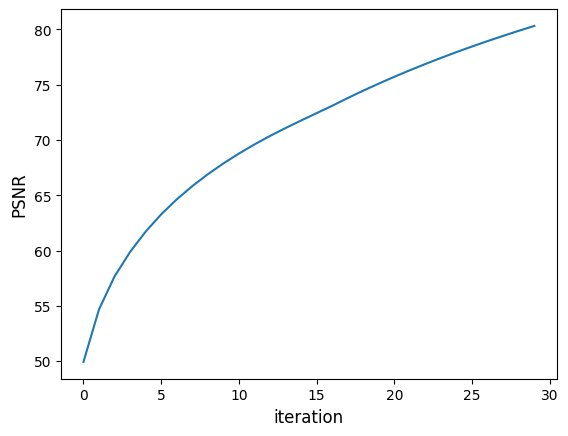

In [5]:
plt.plot([res["metric_gain"] for res in psnr_resolution[1:]])
plt.xlabel("iteration", fontsize=12)
plt.ylabel("PSNR", fontsize=12)
plt.show()

And visualize original and restored images from the iteration at threshold next to each other.

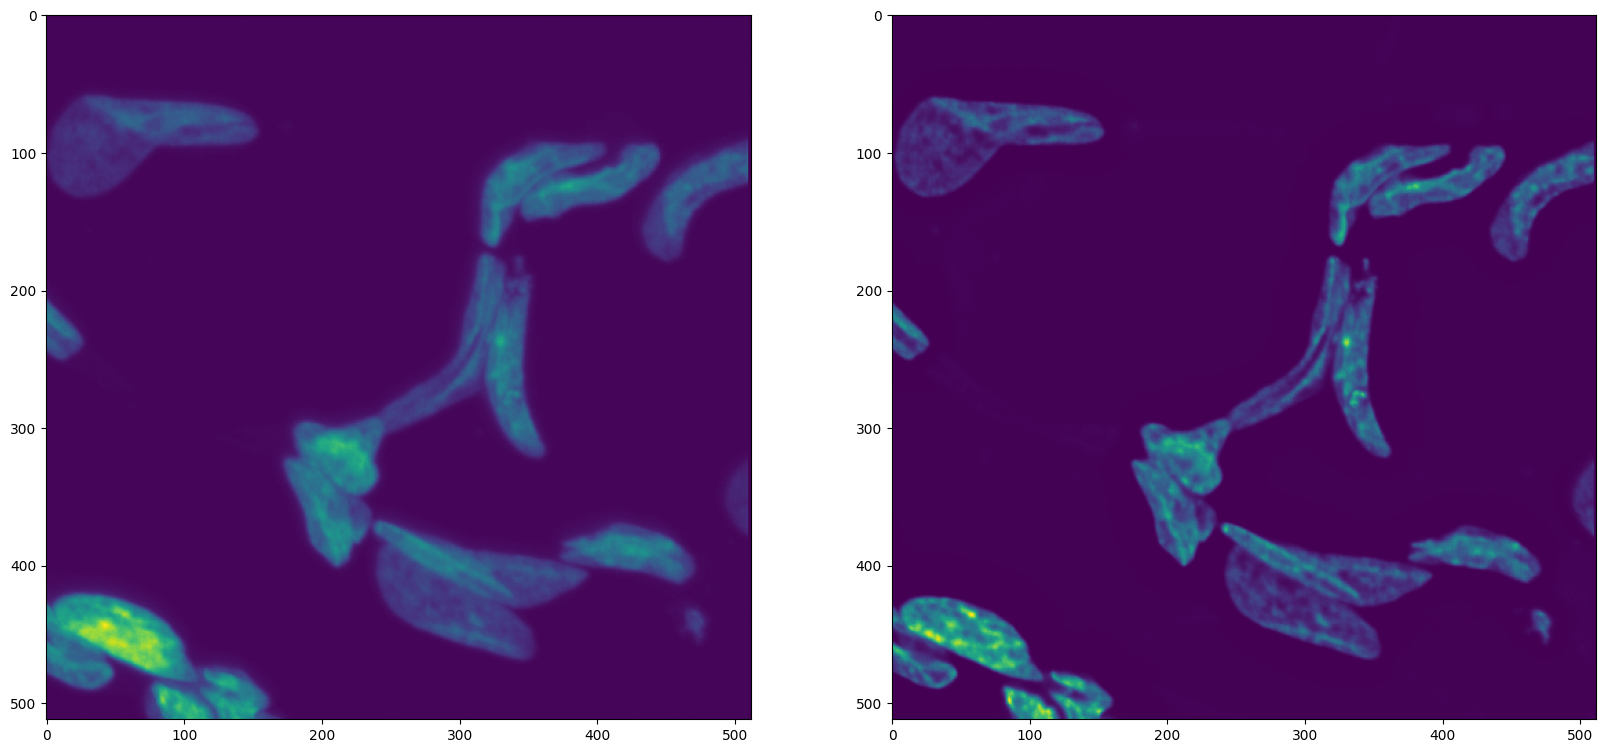

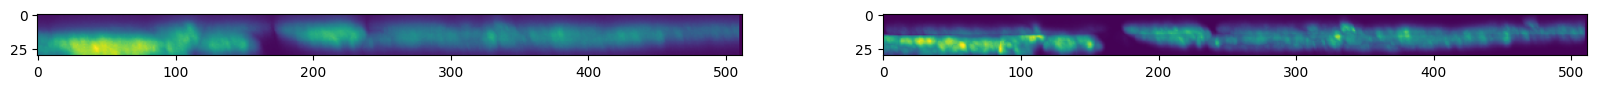

In [6]:
patch = slice(0, image.shape[0]), slice(1024, 1024 + 512), slice(2048, 2048 + 512)
deconv_image = psnr_resolution[psnr_thresh_iter]["iter_image"]

fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes[0].imshow(asnumpy(image[patch].max(0)))
axes[1].imshow(asnumpy(deconv_image[patch].max(0)))
plt.show()
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes[0].imshow(asnumpy(image[patch].max(1)))
axes[1].imshow(asnumpy(deconv_image[patch].max(1)))
plt.show()

### Use SSIM improvement as a metric of decon quality

Now, we repeat the process using structured similarity index (SSIM) as a progress metric instead.

In [7]:
ssim_thresh_iter, ssim_resolution = deconv_iter_num_finder(
    image,
    psf,
    metric_fn=ssim,
    metric_kwargs={"scale_invariant": True},
    metric_threshold=0.99999,
    max_iter=35,
    verbose=True,
    implementation="xpy",
    noncirc=False,
)

Iteration 1: improvement 0.99025995
Iteration 2: improvement 0.99707708
Iteration 3: improvement 0.99860619
Iteration 4: improvement 0.99919281
Iteration 5: improvement 0.99948638
Iteration 6: improvement 0.99965207
Iteration 7: improvement 0.99975336
Iteration 8: improvement 0.99981899
Iteration 9: improvement 0.99986340
Iteration 10: improvement 0.99989447
Iteration 11: improvement 0.99991683
Iteration 12: improvement 0.99993331
Iteration 13: improvement 0.99994570
Iteration 14: improvement 0.99995519
Iteration 15: improvement 0.99996264
Iteration 16: improvement 0.99996862
Iteration 17: improvement 0.99997351
Iteration 18: improvement 0.99997765
Iteration 19: improvement 0.99998099
Iteration 20: improvement 0.99998371
Iteration 21: improvement 0.99998595
Iteration 22: improvement 0.99998780
Iteration 23: improvement 0.99998935
Iteration 24: improvement 0.99999064

Threshold 0.99999 reached at iteration 24 with improvement: 0.99999064.
Metric between original and restored images: 0.9

When visualized, SSIM shows reachin a plateau even before 10 iterations. This makes sense, because SSIM measures the perceived change in structural information, while PSNR estimates an absolute error.

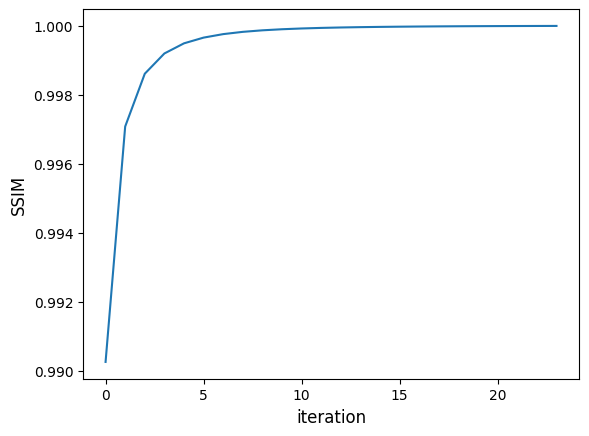

In [8]:
plt.plot([res["metric_gain"] for res in ssim_resolution[1:]])
plt.xlabel("iteration", fontsize=12)
plt.ylabel("SSIM", fontsize=12)
plt.show()

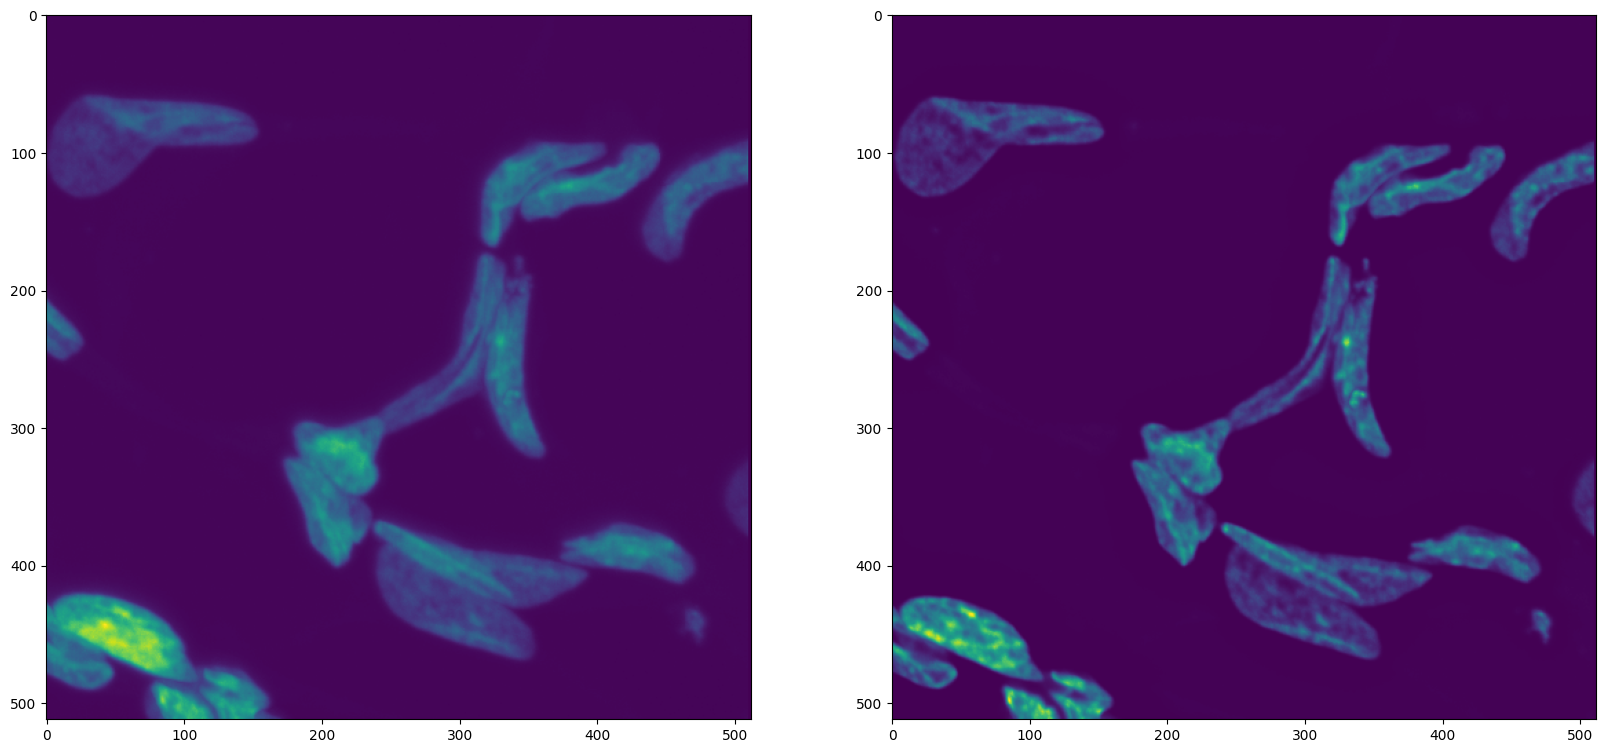

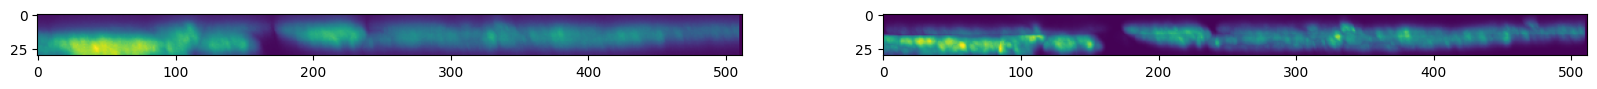

In [9]:
patch = slice(0, image.shape[0]), slice(1024, 1024 + 512), slice(2048, 2048 + 512)
deconv_image = ssim_resolution[ssim_thresh_iter]["iter_image"]

fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes[0].imshow(asnumpy(image[patch].max(0)))
axes[1].imshow(asnumpy(deconv_image[patch].max(0)))
plt.show()
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes[0].imshow(asnumpy(image[patch].max(1)))
axes[1].imshow(asnumpy(deconv_image[patch].max(1)))
plt.show()

### Use FRC-based resolution estimation improvement as a metric of decon quality

Finally, we employ Fourier Ring Correlation (FRC)-based image resolution estimation as a metric of RL progress cubic provides FRC-based resolution metric, which requires a few parameters, for example, `bin_delta`, which sets the thickness of the ring for FRC calculation.

In [10]:
def frc_resolution_difference(image1, image2, bin_delta=3, spacing=1.0, backend="mask"):
    """Calculate difference between FRC-based resulutions of two images."""
    if isinstance(spacing, (int, float)):
        spacing = (spacing, spacing)

    mid_z = image1.shape[0] // 2
    image1_res = frc_resolution(image1[mid_z], bin_delta=bin_delta, spacing=spacing, backend=backend)
    image2_res = frc_resolution(image2[mid_z], bin_delta=bin_delta, spacing=spacing, backend=backend)
    return (image2_res - image1_res) * 1000  # return diff in nm

In [11]:
frc_thresh_iter, frc_resolution_results = deconv_iter_num_finder(
    image,
    psf,
    metric_fn=frc_resolution_difference,
    metric_kwargs={
        "bin_delta": 3,
        "spacing": scale_xy,
        "backend": "hist",
    },
    metric_threshold=-5.0,  # min improvement in nm/it
    max_iter=35,
    verbose=True,
    implementation="xpy",
)

Iteration 1: improvement -27.52428388
Iteration 2: improvement -20.26254659
Iteration 3: improvement -17.44629586
Iteration 4: improvement -15.59661577
Iteration 5: improvement -13.76628067
Iteration 6: improvement -11.95180669
Iteration 7: improvement -10.45087759
Iteration 8: improvement -9.39780351
Iteration 9: improvement -8.52262685
Iteration 10: improvement -7.30134847
Iteration 11: improvement -6.84785654
Iteration 12: improvement -6.03743097
Iteration 13: improvement -5.62638165
Iteration 14: improvement -4.95460678

Threshold -5.0 reached at iteration 14 with improvement: -4.95460678.
Metric between original and restored images: -165.68676183.



Visualization of FRC-based RL progress shows that the estimated number of iterations is similar to one obtained using PSNR.

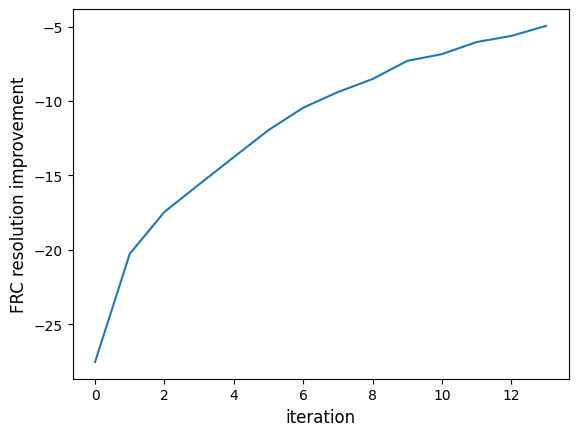

In [12]:
plt.plot([res["metric_gain"] for res in frc_resolution_results[1:]])
plt.xlabel("iteration", fontsize=12)
plt.ylabel("FRC resolution improvement", fontsize=12)
plt.show()

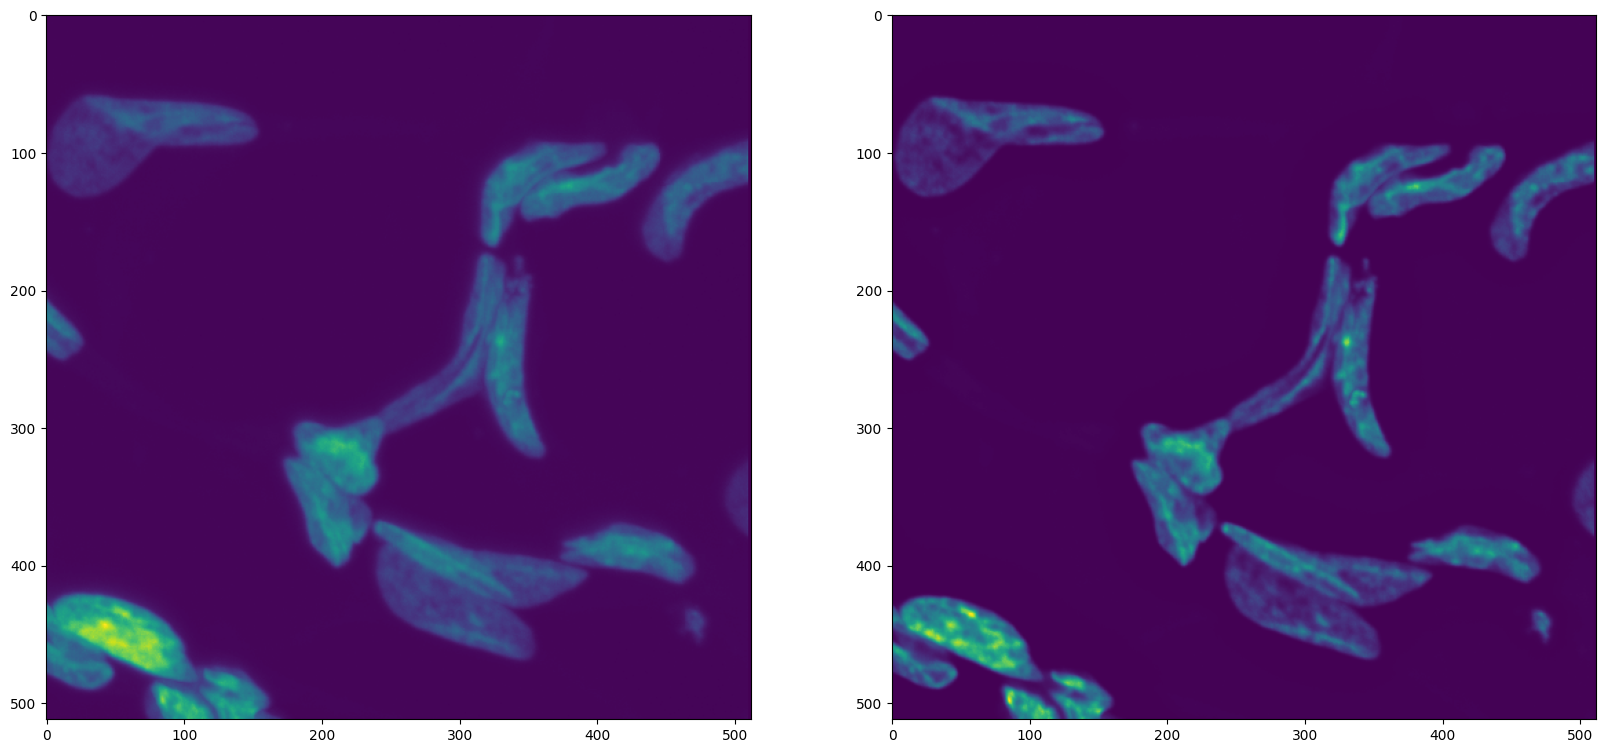

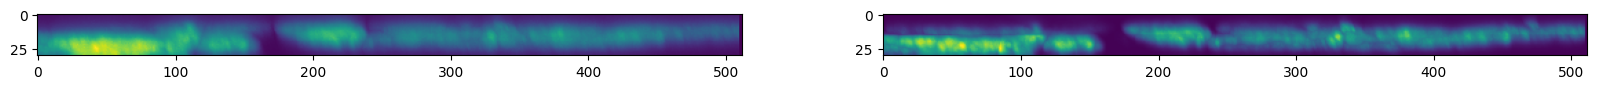

In [13]:
patch = slice(0, image.shape[0]), slice(1024, 1024 + 512), slice(2048, 2048 + 512)
deconv_image = frc_resolution_results[frc_thresh_iter]["iter_image"]

fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes[0].imshow(asnumpy(image[patch].max(0)))
axes[1].imshow(asnumpy(deconv_image[patch].max(0)))
plt.show()
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes[0].imshow(asnumpy(image[patch].max(1)))
axes[1].imshow(asnumpy(deconv_image[patch].max(1)))
plt.show()

[1] D. Sage, L. Donati, F. Soulez, D. Fortun, G. Schmit, A. Seitz, R. Guiet, C. Vonesch, M. Unser, "DeconvolutionLab2: An Open-Source Software for Deconvolution Microscopy," Methods—, vol. 115, 2017. https://bigwww.epfl.ch/algorithms/psfgenerator/

[2] B. Northan, "A collection of useful python utilities from True North Intelligent Algorithms", 2025. https://github.com/True-North-Intelligent-Algorithms/tnia-python